# 撰寫自己的callbacks函數

### callback在訓練時的呼叫時機
> 在 Keras 中，僅需要實作你想要啟動的部分即可
- on_train_begin：在訓練最開始時
- on_train_end：在訓練結束時
- on_batch_begin：在每個 batch 開始時
- on_batch_end：在每個 batch 結束時
- on_epoch_begin：在每個 epoch 開始時
- on_epoch_end：在每個 epoch 結束時

## 範例重點
* 學習如何在 keras 中加入自定義的 callbacks
* 知道 callback function 可以動作的時機

In [1]:
import os
from tensorflow import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y  

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [10]:
"""
# 載入 Callbacks，撰寫一個 f1 score 的 callback function
"""

from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score
import numpy as np

class f1sc(Callback):
    def __init__(self, valid_data):
        super(f1sc, self).__init__()
        self.validation_data = valid_data
    
    def on_epoch_end(self, epoch, logs = {}):
        logs = logs or {}
        y_targ = self.validation_data[1]
        if len(y_targ.shape) == 2 and y_targ.shape[1] != 1:
            y_targ = np.argmax(y_targ, -1)
        y_pred = np.argmax(self.model.predict(self.validation_data[0]), -1)
        v_f1sc = f1_score(y_targ, y_pred, average='macro')
        logs["val_f1sc"] = v_f1sc 
        print(" — val_f1: %f" %v_f1sc)

In [11]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[f1sc(valid_data=(x_test,y_test))]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

# 在訓練後，將 f1sc 紀錄調出
valid_f1sc = model.history.history['val_f1sc']

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_v2_5 (Ba (None, 128)               512 

Epoch 27/50
50000/50000 [==============================] - 9s 181us/sample - loss: 0.9222 - accuracy: 0.6922 - val_loss: 1.4676 - val_accuracy: 0.4988
Epoch 28/50
50000/50000 [==============================] - 9s 189us/sample - loss: 0.9019 - accuracy: 0.7007 - val_loss: 1.4739 - val_accuracy: 0.4958
Epoch 29/50
50000/50000 [==============================] - 9s 174us/sample - loss: 0.8845 - accuracy: 0.7086 - val_loss: 1.4648 - val_accuracy: 0.4982
Epoch 30/50
50000/50000 [==============================] - 9s 182us/sample - loss: 0.8608 - accuracy: 0.7168 - val_loss: 1.4685 - val_accuracy: 0.5039
Epoch 31/50
50000/50000 [==============================] - 8s 162us/sample - loss: 0.8437 - accuracy: 0.7229 - val_loss: 1.4849 - val_accuracy: 0.4981
Epoch 32/50
50000/50000 [==============================] - 9s 172us/sample - loss: 0.8242 - accuracy: 0.7308 - val_loss: 1.4882 - val_accuracy: 0.4948
Epoch 33/50
50000/50000 [==============================] - 10s 208us/sample - loss: 0.8049 - a

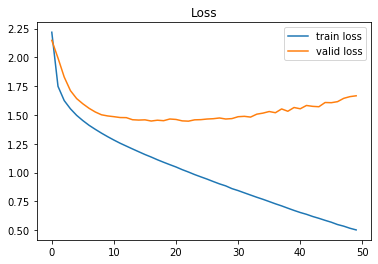

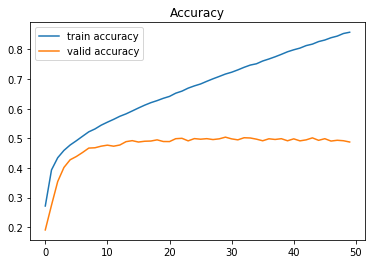

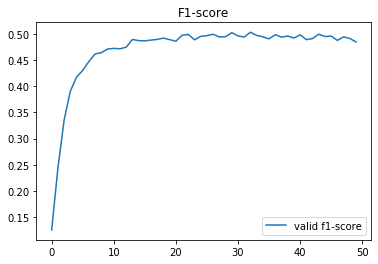

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_f1sc)), valid_f1sc, label="valid f1-score")
plt.legend()
plt.title("F1-score")
plt.show()

In [9]:
# 載入 Callbacks
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score
import numpy as np

# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def __init__(self, valid_data):
        super(Record_tp_tn, self).__init__()
        self.validation_data = valid_data
            
    
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0]).argmax(axis = 1)
        
        #logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        tp=np.sum((y_pred!=0)*(y_pred==y_true))
        tn=np.sum((y_pred==0)*(y_true==0))
        logs["val_tp"]=tp
        logs["val_tn"]=tn
        print("- val_tp:%f,- val_tn:%f"%(tp,tn))
    

In [10]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[Record_tp_tn(valid_data=(x_test,y_test))]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp = model.history.history["val_tp"]
valid_tn = model.history.history["val_tn"]


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v2_3 (Ba (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v2_4 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_v2_5 (Ba (None, 128)               512 

50000/50000 [==============================] - 8s 163us/sample - loss: 0.9556 - accuracy: 0.6817 - val_loss: 1.4900 - val_accuracy: 0.4916
Epoch 26/50
50000/50000 [==============================] - 8s 156us/sample - loss: 0.9388 - accuracy: 0.6871 - val_loss: 1.4803 - val_accuracy: 0.4872
Epoch 27/50
50000/50000 [==============================] - 8s 157us/sample - loss: 0.9150 - accuracy: 0.6963 - val_loss: 1.4870 - val_accuracy: 0.4948
Epoch 28/50
50000/50000 [==============================] - 8s 160us/sample - loss: 0.8973 - accuracy: 0.7034 - val_loss: 1.4990 - val_accuracy: 0.4916
Epoch 29/50
50000/50000 [==============================] - 8s 161us/sample - loss: 0.8767 - accuracy: 0.7125 - val_loss: 1.4863 - val_accuracy: 0.4960
Epoch 30/50
50000/50000 [==============================] - 8s 155us/sample - loss: 0.8567 - accuracy: 0.7207 - val_loss: 1.4926 - val_accuracy: 0.4993
Epoch 31/50
50000/50000 [==============================] - 8s 161us/sample - loss: 0.8369 - accuracy: 0.72

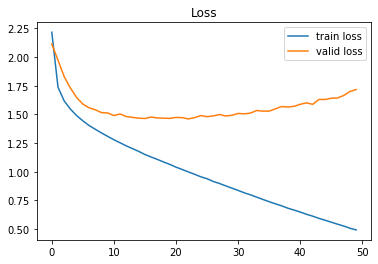

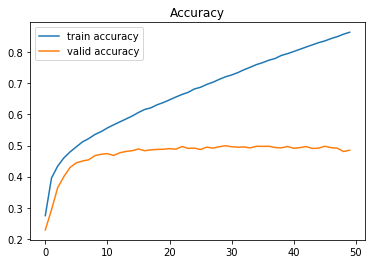

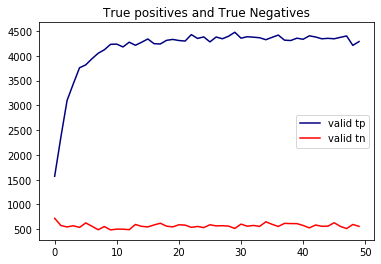

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()


# 撰写自己的Loss function
> 一个损失函数必须有：
- 有y_true 与 y_pred两个输入
- 可以微分
- 使用tensor operation.

## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


[大型翻车现场，升级到tensorflow 2.0，我整个人都不好了](https://cloud.tencent.com/developer/article/1524140)

In [14]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import tensorflow.keras.backend as K

"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
自定義的 loss function: focal loss (https://blog.csdn.net/u014380165/article/details/77019084)
"""
def combined_loss(ratio=0.3,gamma=2., alpha=4.):
    ratio=float(ratio)
    gamma = float(gamma)
    alpha = float(alpha)
    def combined_loss_fixed(y_true,y_pred):
        
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        focal_loss=tf.reduce_mean(reduced_fl)
        cross_entropy=K.categorical_crossentropy(y_pred, y_true)
        return ratio*focal_loss+(1-ratio)*cross_entropy
    return combined_loss_fixed

ce_weights_list = [0., 0.3, 0.5, 0.7, 1]

W1210 08:25:01.620338 140668 deprecation.py:323] From C:\Users\qishi shi\Anaconda3\lib\site-packages\tensorflow\python\compat\v2_compat.py:63: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [15]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list):
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss=combined_loss(ratio=ce_w), metrics=["accuracy"], optimizer=optimizer)
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True
             )
    
    # Collect results
    exp_name_tag = ("exp-%s" % str(ce_w))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W1210 08:26:21.245308 140668 deprecation.py:506] From C:\Users\qishi shi\Anaconda3\lib\site-packages\tensorflow\python\ops\init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Numbers of exp: 0, ce_weight: 0.00
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v2_6 (Ba (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_v2_7 (Ba (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_v2_8

50000/50000 [==============================] - 7s 141us/sample - loss: 3.1698 - acc: 0.8137 - val_loss: 8.1309 - val_acc: 0.5033
Epoch 49/50
50000/50000 [==============================] - 7s 136us/sample - loss: 3.1390 - acc: 0.8148 - val_loss: 8.2145 - val_acc: 0.4959
Epoch 50/50
50000/50000 [==============================] - 7s 143us/sample - loss: 3.1076 - acc: 0.8165 - val_loss: 8.1714 - val_acc: 0.4994
Numbers of exp: 1, ce_weight: 0.30
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_v2_9 (Ba (None, 512)               2048      
_________________________________________________________________
hidden_la

50000/50000 [==============================] - 7s 135us/sample - loss: 0.9194 - acc: 0.9624 - val_loss: 9.6793 - val_acc: 0.4675
Epoch 46/50
50000/50000 [==============================] - 10s 206us/sample - loss: 0.8885 - acc: 0.9634 - val_loss: 9.7028 - val_acc: 0.4767
Epoch 47/50
50000/50000 [==============================] - 11s 226us/sample - loss: 0.8367 - acc: 0.9664 - val_loss: 9.8074 - val_acc: 0.4702
Epoch 48/50
50000/50000 [==============================] - 10s 209us/sample - loss: 0.7765 - acc: 0.9688 - val_loss: 9.6969 - val_acc: 0.4726
Epoch 49/50
50000/50000 [==============================] - 7s 150us/sample - loss: 0.7160 - acc: 0.9716 - val_loss: 9.8906 - val_acc: 0.4700
Epoch 50/50
50000/50000 [==============================] - 7s 145us/sample - loss: 0.6665 - acc: 0.9742 - val_loss: 10.0359 - val_acc: 0.4610
Numbers of exp: 2, ce_weight: 0.50
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape   

50000/50000 [==============================] - 7s 135us/sample - loss: 0.6660 - acc: 0.9736 - val_loss: 10.0230 - val_acc: 0.4521
Epoch 43/50
50000/50000 [==============================] - 7s 139us/sample - loss: 0.6070 - acc: 0.9770 - val_loss: 9.7667 - val_acc: 0.4746
Epoch 44/50
50000/50000 [==============================] - 7s 136us/sample - loss: 0.5550 - acc: 0.9793 - val_loss: 9.6485 - val_acc: 0.4765
Epoch 45/50
50000/50000 [==============================] - 7s 135us/sample - loss: 0.5030 - acc: 0.9825 - val_loss: 10.2000 - val_acc: 0.4724
Epoch 46/50
50000/50000 [==============================] - 7s 136us/sample - loss: 0.4378 - acc: 0.9862 - val_loss: 10.0268 - val_acc: 0.4742
Epoch 47/50
50000/50000 [==============================] - 7s 136us/sample - loss: 0.3986 - acc: 0.9873 - val_loss: 10.0843 - val_acc: 0.4771
Epoch 48/50
50000/50000 [==============================] - 7s 136us/sample - loss: 0.3666 - acc: 0.9891 - val_loss: 10.4294 - val_acc: 0.4589
Epoch 49/50
50000/50

50000/50000 [==============================] - 7s 139us/sample - loss: 0.6037 - acc: 0.9723 - val_loss: 8.4599 - val_acc: 0.4874
Epoch 40/50
50000/50000 [==============================] - 7s 137us/sample - loss: 0.5565 - acc: 0.9762 - val_loss: 8.9774 - val_acc: 0.4696
Epoch 41/50
50000/50000 [==============================] - 7s 142us/sample - loss: 0.5056 - acc: 0.9795 - val_loss: 8.7853 - val_acc: 0.4866
Epoch 42/50
50000/50000 [==============================] - 7s 137us/sample - loss: 0.4596 - acc: 0.9825 - val_loss: 9.0873 - val_acc: 0.4801
Epoch 43/50
50000/50000 [==============================] - 7s 136us/sample - loss: 0.4080 - acc: 0.9854 - val_loss: 8.9533 - val_acc: 0.4834
Epoch 44/50
50000/50000 [==============================] - 7s 141us/sample - loss: 0.3698 - acc: 0.9882 - val_loss: 9.2886 - val_acc: 0.4817
Epoch 45/50
50000/50000 [==============================] - 7s 141us/sample - loss: 0.3277 - acc: 0.9907 - val_loss: 9.1330 - val_acc: 0.4835
Epoch 46/50
50000/50000 [

50000/50000 [==============================] - 7s 136us/sample - loss: 0.3972 - acc: 0.9318 - val_loss: 5.5624 - val_acc: 0.4818
Epoch 37/50
50000/50000 [==============================] - 7s 137us/sample - loss: 0.3541 - acc: 0.9412 - val_loss: 5.5976 - val_acc: 0.4781
Epoch 38/50
50000/50000 [==============================] - 7s 137us/sample - loss: 0.3198 - acc: 0.9475 - val_loss: 5.7654 - val_acc: 0.4705
Epoch 39/50
50000/50000 [==============================] - 7s 136us/sample - loss: 0.2849 - acc: 0.9545 - val_loss: 5.6524 - val_acc: 0.4747
Epoch 40/50
50000/50000 [==============================] - 7s 135us/sample - loss: 0.2554 - acc: 0.9611 - val_loss: 5.8079 - val_acc: 0.4763
Epoch 41/50
50000/50000 [==============================] - 7s 138us/sample - loss: 0.2358 - acc: 0.9642 - val_loss: 5.9072 - val_acc: 0.4688
Epoch 42/50
50000/50000 [==============================] - 7s 137us/sample - loss: 0.2173 - acc: 0.9666 - val_loss: 6.0613 - val_acc: 0.4681
Epoch 43/50
50000/50000 [

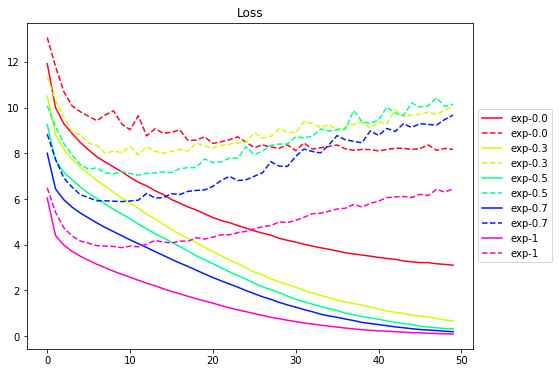

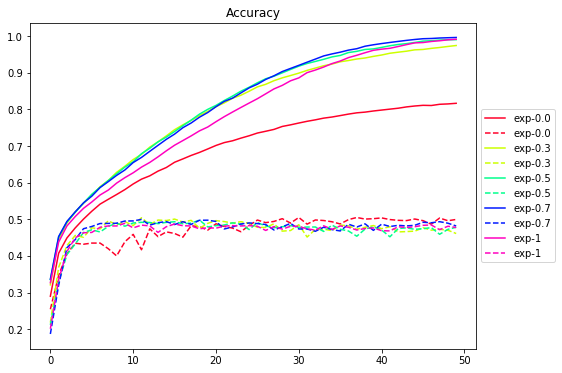

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()